<a href="https://colab.research.google.com/github/Charliongithub/DM2024-Lab2-Master/blob/main/Lab2_ex12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training DataFrame Shape: (3613, 4)
Testing DataFrame Shape: (347, 4)
         id                                               text  emotion  \
1704  20847  @realDonaldTrump @KellyannePolls New campaign ...     fear   
1152  20295  We in our own country are so divided in our ap...     fear   
1038  20181  @twlldun @bbcquestiontime @JacobReesMogg @leic...     fear   
3497  40670  #PeopleLikeMeBecause of some unknown reason bu...  sadness   
1940  21083  @BigDaddyx47 awe I'm sorry! I have 2 dogs 3 ca...     fear   

      intensity  
1704      0.354  
1152      0.625  
1038      0.696  
3497      0.278  
1940      0.188  
KNN Classification Report:
              precision    recall  f1-score   support

       anger       0.20      0.26      0.23        84
        fear       0.33      0.42      0.37       110
         joy       0.28      0.24      0.26        79
     sadness       0.20      0.08      0.12        74

    accuracy                           0.27       347
   macro avg      

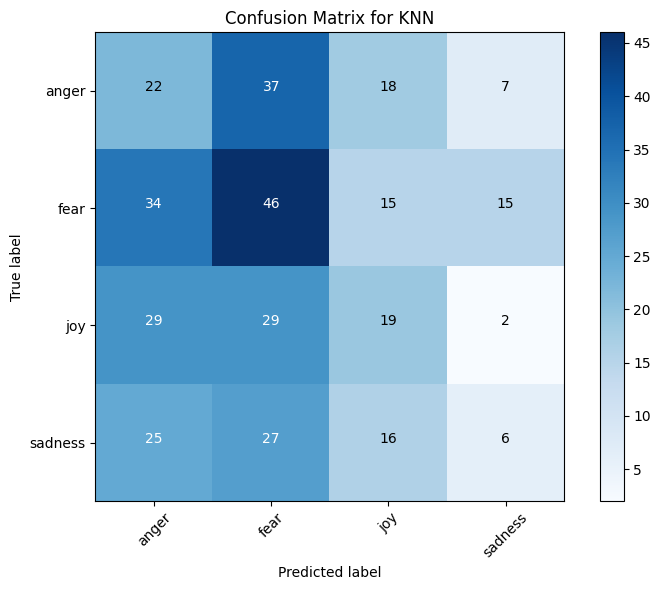

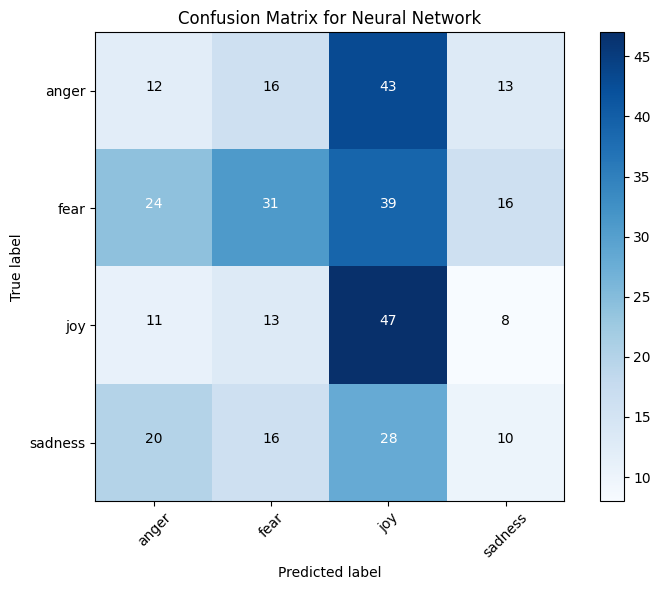

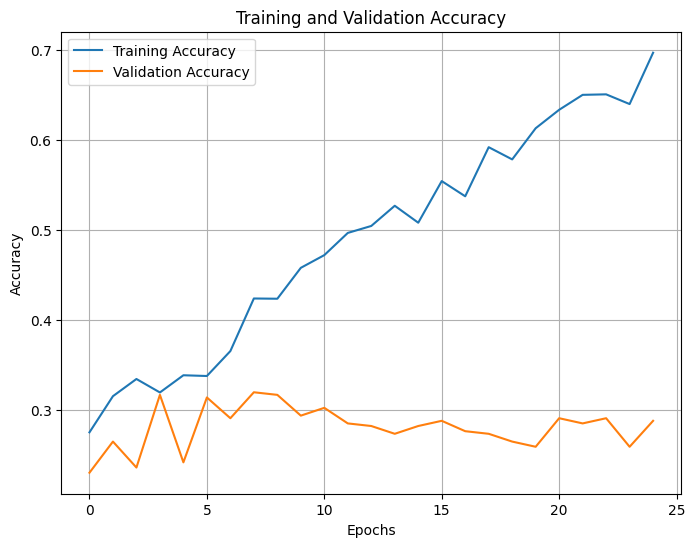

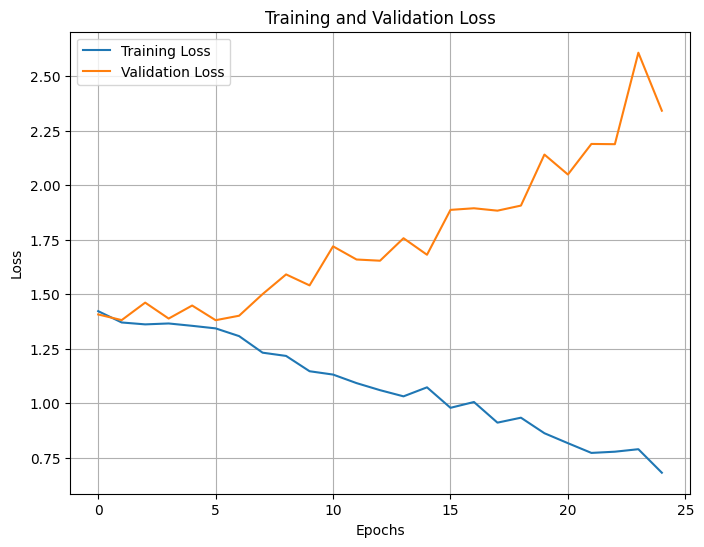

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense, ReLU, Softmax
import matplotlib.pyplot as plt
import seaborn as sns

# Define necessary functions
def plot_training_validation(history):
    # Plot Training and Validation Accuracy
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Training and Validation Loss
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Define dataset path
didiersalazar_lab2_dataset_path = "https://raw.githubusercontent.com/didiersalazar/DM2024-Lab2-Master/main/data"

# Load and prepare data
train_df = pd.read_pickle(f"{didiersalazar_lab2_dataset_path}/train_df.pkl")
test_df = pd.read_pickle(f"{didiersalazar_lab2_dataset_path}/test_df.pkl")

# Verify data
print("Training DataFrame Shape:", train_df.shape)
print("Testing DataFrame Shape:", test_df.shape)
print(train_df.head())

# Prepare LLM embeddings
# Replace with function generating embeddings from your model (e.g., Llama3.2)
def dummy_generate_embeddings(row, text_column_name='text'):
    return np.random.rand(3072)  # Placeholder embeddings

train_df['embeddings'] = train_df.apply(lambda row: dummy_generate_embeddings(row, 'text'), axis=1)
test_df['embeddings'] = test_df.apply(lambda row: dummy_generate_embeddings(row, 'text'), axis=1)

# KNN Model
X_train_knn = train_df['embeddings'].tolist()
y_train_knn = train_df['emotion']
X_test_knn = test_df['embeddings'].tolist()
y_test_knn = test_df['emotion']

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_knn, y_train_knn)
y_pred_knn = knn.predict(X_test_knn)

print("KNN Classification Report:")
print(classification_report(y_true=y_test_knn, y_pred=y_pred_knn))
cm_knn = confusion_matrix(y_true=y_test_knn, y_pred=y_pred_knn)
plot_confusion_matrix(cm_knn, classes=['anger', 'fear', 'joy', 'sadness'], title='Confusion Matrix for KNN')

# Neural Network Model
X_train_nn = np.vstack(train_df['embeddings'].to_numpy())
X_test_nn = np.vstack(test_df['embeddings'].to_numpy())
y_train_nn = pd.get_dummies(train_df['emotion']).values
y_test_nn = pd.get_dummies(test_df['emotion']).values

input_shape_nn = X_train_nn.shape[1]
output_shape_nn = y_train_nn.shape[1]

model_input = Input(shape=(input_shape_nn,))
X = model_input
X_W1 = Dense(units=64)(X)
H1 = ReLU()(X_W1)
H1_W2 = Dense(units=64)(H1)
H2 = ReLU()(H1_W2)
H2_W3 = Dense(units=output_shape_nn)(H2)
H3 = Softmax()(H2_W3)

model_nn = Model(inputs=[model_input], outputs=[H3])
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history_nn = model_nn.fit(X_train_nn, y_train_nn,
                          epochs=25,
                          batch_size=32,
                          validation_data=(X_test_nn, y_test_nn))

print("Neural Network Classification Report:")
predictions_nn = model_nn.predict(X_test_nn, batch_size=128)
y_pred_nn = pd.DataFrame(predictions_nn, columns=['anger', 'fear', 'joy', 'sadness']).idxmax(axis=1)
y_true_nn = pd.DataFrame(y_test_nn, columns=['anger', 'fear', 'joy', 'sadness']).idxmax(axis=1)
print(classification_report(y_true=y_true_nn, y_pred=y_pred_nn))
cm_nn = confusion_matrix(y_true=y_true_nn, y_pred=y_pred_nn)
plot_confusion_matrix(cm_nn, classes=['anger', 'fear', 'joy', 'sadness'], title='Confusion Matrix for Neural Network')

# Plot Training and Validation Accuracy and Loss for Neural Network
plot_training_validation(history_nn)


** >>> Exercise 12 (Take home): **

Follow Exercise 6 again and Plot the Training and Validation Accuracy and Loss for the results of this Neural Network. Compare the results of both KNN and the NN we just implemented. Discuss about why we obtained these results with the LLM Embeddings compared to the results of the other models implemented in this Lab.

